In [1]:
import cv2
import numpy as np


In [2]:
import imutils
import matplotlib.pyplot as plt

[[297 421]
 [224 419]
 [225 376]
 [298 377]]
[[290, 411], [225, 419], [247, 390], [294, 387]]


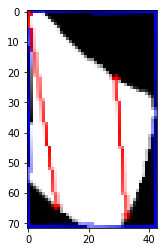

In [17]:
image = cv2.imread('test_mask/masks/7.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)
# plt.imshow(thresh, cmap="gray")
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
rect = cv2.minAreaRect(cnts[0])
box = cv2.boxPoints(rect)
box = np.int0(box)
print(box)
plt.imshow(cv2.drawContours(image, [box], 0, (0, 0, 255), 1))
true_corners = []
for pt in box:
    true_corners.append(min([(x, np.linalg.norm(x-pt)) for x in cnts[0]], key = lambda t: t[1])[0].tolist()[0])
    
print(true_corners)
for pt in true_corners:
    (x, y) = pt
    cv2.circle(image, (x,y), 1, (255,0,0), thickness=1, lineType=8, shift=0)

tl_x, tl_y = true_corners[0]
t2_x, t2_y = true_corners[1]

cv2.line(image, (tl_x, tl_y), (t2_x, t2_y), (255,0,0), thickness=1, lineType=8, shift=0)


t3_x, t3_y = true_corners[2]
t4_x, t4_y = true_corners[3]

cv2.line(image, (t3_x, t3_y), (t4_x, t4_y), (255,0,0), thickness=1, lineType=8, shift=0)

# cv.Circle(img, center, radius, color, thickness=1, lineType=8, shift=0)
width = int(rect[1][0])
height = int(rect[1][1])

src_pts = box.astype("float32")
dst_pts = np.array([[0, height-1],
                    [0, 0],
                    [width-1, 0],
                    [width-1, height-1]], dtype="float32")
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warped = cv2.warpPerspective(image, M, (width, height))

plt.imshow(warped)
